# 6. Mạng Nơ-ron Tích chập

Trong những chương đầu tiên, chúng ta đã làm việc trên dữ liệu ảnh với mỗi mẫu là một mảng điểm ảnh 2D. Tùy vào ảnh đen trắng hay ảnh màu mà ta cần xử lý một hay nhiều giá trị số học tương ứng tại mỗi vị trí điểm ảnh. Cho đến nay, cách ta xử lý dữ liệu với cấu trúc phong phú này vẫn chưa thật sự thoả đáng. Ta chỉ đang đơn thuần loại bỏ cấu trúc không gian từ mỗi bức ảnh bằng cách chuyển chúng thành các vector và truyền chúng qua một mạng MLP (kết nối đầy đủ). Vì các mạng này là bất biến với thứ tự của các đặc trưng, ta sẽ nhận được cùng một kết quả bất kể việc chúng ta có giữ lại thứ tự cấu trúc không gian của các điểm ảnh hay hoán vị các cột của ma trận đặc trưng trước khi khớp các tham số của mạng MLP. Tốt hơn hết, ta nên tận dụng điều đã biết là các điểm ảnh kề cận thường có tương quan lẫn nhau, để xây dựng những mô hình hiệu quả hơn cho việc học từ dữ liệu ảnh.

Chương này sẽ giới thiệu về các Mạng Nơ-ron Tích chập (**Convolutional Neural Network - CNN**), một họ các mạng nơ-ron ưu việt được thiết kế chính xác cho mục đích trên. Các kiến trúc dựa trên CNN hiện nay xuất hiện trong mọi ngóc ngách của lĩnh vực thị giác máy tính, và đã trở thành kiến trúc chủ đạo mà hiếm ai ngày nay phát triển các ứng dụng thương mại hay tham gia một cuộc thi nào đó liên quan tới nhận dạng ảnh, phát hiện đối tượng, hay phân vùng theo ngữ cảnh mà không xây nền móng dựa trên phương pháp này.


Theo cách hiểu thông dụng, thiết kế của mạng ConvNets đã vay mượn rất nhiều ý tưởng từ ngành sinh học, lý thuyết nhóm và lượng rất nhiều những thí nghiệm nhỏ lẻ khác. Bên cạnh hiệu năng cao trên số lượng mẫu cần thiết để đạt được đủ độ chính xác, các mạng nơ-ron tích chập thường có hiệu quả tính toán hơn, bởi đòi hỏi ít tham số hơn và dễ thực thi song song trên nhiều GPU hơn các kiến trúc mạng dày đặc.
Do đó, các mạng CNN sẽ được áp dụng bất cứ khi nào có thể, và chúng đã nhanh chóng trở thành một công cụ quan trọng đáng tin cậy thậm chí với các tác vụ liên quan tới cấu trúc tuần tự một chiều, như là xử lý âm thanh, văn bản, và phân tích dữ liệu chuỗi thời gian (time series analysis), mà ở đó các mạng nơ-rơn hồi tiếp vốn thường được sử dụng. Với một số điều chỉnh khôn khéo, ta còn có thể dùng mạng CNN cho dữ liệu có cấu trúc đồ thị và hệ thống đề xuất.

Trước hết, chúng ta sẽ đi qua các phép toán cơ bản nhằm tạo nên bộ khung sườn của tất cả các mạng nơ-ron tích chập. Chúng bao gồm các tầng tích chập, các chi tiết cơ bản quan trọng như đệm và sải bước, các tầng gộp dùng để kết hợp thông tin qua các vùng không gian kề nhau, việc sử dụng đa kênh (cũng được gọi là các bộ lọc) ở mỗi tầng và một cuộc thảo luận cẩn thận về cấu trúc của các mạng hiện đại. Chúng ta sẽ kết thúc cho chương này với một ví dụ hoàn toàn hoạt động của mạng LeNet, mạng tích chập đầu tiên đã triển khai thành công và tồn tại nhiều năm trước khi có sự trỗi dậy của kỹ thuật học sâu hiện đại. Ở chương kế tiếp, chúng ta sẽ đắm mình vào việc xây dựng hoàn chỉnh một số kiến trúc CNN tương đối gần đây và khá phổ biến. Thiết kế của chúng chứa hầu hết những kỹ thuật mà ngày nay hay được sử dụng.

## 6.1. Từ Tầng Kết nối Dày đặc đến phép Tích chập
Đến nay, các mô hình mà ta đã thảo luận là các lựa chọn phù hợp nếu dữ liệu mà ta đang xử lý có dạng bảng với các hàng tương ứng với các mẫu, còn các cột tương ứng với các đặc trưng. Với dữ liệu có dạng như vậy, ta có thể dự đoán rằng khuôn mẫu mà ta đang tìm kiếm có thể yêu cầu việc mô hình hóa sự tương tác giữa các đặc trưng, nhưng ta không giả định trước rằng những đặc trưng nào liên quan tới nhau và mối quan hệ của chúng.

Hãy quay trở lại với ví dụ phân biệt chó và mèo quen thuộc. Giả sử ta đã thực hiện việc thu thập dữ liệu một cách kỹ lưỡng và thu được một bộ ảnh được gán nhãn chất lượng cao với độ phân giải 1 triệu điểm ảnh. Điều này có nghĩa là đầu vào của mạng sẽ có 1 triệu chiều. Ngay cả việc giảm mạnh xuống còn 1000 chiều ẩn sẽ cần tới một tầng dày đặc (kết nối đầy đủ) có $10^9$
tham số. Trừ khi ta có một tập dữ liệu cực lớn (có thể là hàng tỷ ảnh?), một số lượng lớn GPU, chuyên môn cao trong việc tối ưu hóa phân tán và sức kiên nhẫn phi thường, việc học các tham số của mạng này có thể là điều bất khả thi.

Độc giả kỹ tính có thể phản đối lập luận này trên cơ sở độ phân giải 1 triệu điểm ảnh có thể là không cần thiết. Tuy nhiên, ngay cả khi chỉ sử dụng 100.000 điểm ảnh, ta đã đánh giá quá thấp số lượng các nút ẩn cần thiết để tìm các biểu diễn ẩn tốt của các ảnh. Việc học một bộ phân loại nhị phân với rất nhiều tham số có thể sẽ cần tới một tập dữ liệu khổng lồ, có lẽ tương đương với số lượng chó và mèo trên hành tinh này. Tuy nhiên, việc cả con người và máy tính đều có thể phân biệt mèo với chó khá tốt dường như mâu thuẫn với các kết luận trên. Đó là bởi vì các ảnh thể hiện cấu trúc phong phú, thường được khai thác bởi con người và các mô hình học máy theo các cách giống nhau.

### 6.1.1. Tính Bất biến
Hãy tưởng tượng rằng ta muốn nhận diện một vật thể trong ảnh. Có vẻ sẽ hợp lý nếu cho rằng bất cứ phương pháp nào ta sử dụng đều không nên quá quan tâm đến vị trí chính xác của vật thể trong ảnh. Lý tưởng nhất, ta có thể học một hệ thống có khả năng tận dụng được kiến thức này bằng một cách nào đó. Lợn thường không bay và máy bay thường không bơi. Tuy nhiên, ta vẫn có thể nhận ra một con lợn đang bay nếu nó xuất hiện.

Quay lại với ảnh, những trực giác mà ta đã thảo luận có thể được cụ thể hóa hơn nữa để thu được một vài nguyên tắc chính trong việc xây dựng mạng nơ-ron cho thị giác máy tính:

   * Ở một khía cạnh nào đó, các hệ thống thị giác nên phản ứng tương tự với cùng một vật thể bất kể vật thể đó xuất hiện ở đâu trong ảnh (**tính bất biến tịnh tiến-translation invariance**).
   * Ở khía cạnh khác, các hệ thống thị giác nên tập trung vào các khu vực cục bộ và không quan tâm đến bất kỳ thứ gì khác ở xa hơn trong ảnh (**tính cục bộ-locality principle**).

Hãy cùng xem cách biểu diễn những điều trên bằng ngôn ngữ toán học.

### 6.1.2. Ràng buộc Perceptron Đa tầng
Trong phần này, ta coi hình ảnh và các tầng ẩn là các mảng hai chiều. Để bắt đầu, hãy tưởng tượng một perceptron đa tầng sẽ như thế nào với đầu vào là ảnh kích thước $h×w$ (biểu diễn dưới dạng ma trận trong toán học và mảng hai chiều khi lập trình), và với các biểu diễn ẩn cũng là các ma trận / mảng hai chiều kích thước $h×w$. Đặt $x[i,j]$ và $h[i,j]$ lần lượt là điểm ảnh tại vị trí $(i,j)$ của ảnh và biểu diễn ẩn. Để mỗi nút ẩn trong tổng số $h×w$ nút nhận dữ liệu từ tất cả $h×w$ đầu vào, ta sẽ chuyển từ việc biểu diễn các tham số bằng ma trận trọng số (như đã thực hiện với perceptron đa tầng trước đây) sang sử dụng các tensor trọng số bốn chiều.

Ta có thể biểu diễn tầng kết nối đầy đủ bằng công thức toán sau:

<center>$h[i, j] = u[i, j] + \sum_{k, l} W[i, j, k, l] \cdot x[k, l] =  u[i, j] +
\sum_{a, b} V[i, j, a, b] \cdot x[i+a, j+b].$</center>

Việc chuyển từ $W$ sang $V$ hoàn toàn chỉ có mục đích thẩm mĩ (tại thời điểm này) bởi có một sự tương ứng một-một giữa các hệ số trong cả hai tensor. Ta chỉ đơn thuần đặt lại các chỉ số dưới $(k,l)$ với $k=i+a$ và $l=j+b$. Nói cách khác, $V[i,j,a,b]=W[i,j,i+a,j+b]$. Các chỉ số $a,b$ chạy trên toàn bộ hình ảnh, có thể mang cả giá trị dương và âm. Với bất kỳ vị trí $(i,j)$ nào ở tầng ẩn, giá trị biểu diễn ẩn $h[i,j]$ được tính bằng tổng trọng số của các điểm ảnh nằm xung quanh vị trí $(i,j)$ của $x$, với trọng số là $V[i,j,a,b]$.

Bây giờ hãy sử dụng nguyên tắc đầu tiên mà ta đã thiết lập ở trên: **tính bất biến tịnh tiến**. Nguyên tắc này ngụ ý rằng một sự dịch chuyển ở đầu vào $x$ cũng sẽ tạo ra sự dịch chuyển ở biểu diễn ẩn $h$. Điều này chỉ có thể xảy ra nếu $V$ và $u$ không phụ thuộc vào $(i,j)$, tức $V[i,j,a,b]=V[a,b]$ và $u$ là một hằng số. Vì vậy, ta có thể đơn giản hóa định nghĩa của $h$.


<center>$h[i, j] = u + \sum_{a, b} V[a, b] \cdot x[i+a, j+b]$</center>

Đây là một phép tích chập! Ta đang đánh trọng số cho các điểm ảnh $(i+a,j+b)$ trong vùng lân cận của $(i,j)$ bằng các hệ số $V[a,b]$ để thu được giá trị $h[i,j]$. Lưu ý rằng $V[a,b]$ cần ít hệ số hơn hẳn so với $V[i,j,a,b]$. Với đầu vào là hình ảnh 1 megapixel (với tối đa 1 triệu hệ số cho mỗi vị trí), lượng tham số của $V[a,b]$ giảm đi 1 triệu vì không còn phụ thuộc vào vị trí trong ảnh. Ta đã có được tiến triển đáng kể!

Bây giờ hãy sử dụng nguyên tắc thứ hai—**tính cục bộ**. Như trình bày ở trên, giả sử rằng ta không cần thông tin tại các vị trí quá xa $(i,j)$ để đánh giá những gì đang diễn ra tại $h[i,j]$. Điều này có nghĩa là ở các miền giá trị $|a|,|b|>Δ$, ta có thể đặt $V[a,b]=0$. Tương tự, ta có thể đơn giản hoá $h[i,j]$ như sau:


<center>$h[i, j] = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} V[a, b] \cdot x[i+a, j+b]$</center>

### 6.1.3. Phép Tích chập
Hãy cùng xem qua lý do tại sao toán tử trên được gọi là **tích chập**. Trong toán học, phép tích chập giữa hai hàm số  $f, g: \mathbb{R}^d \to R$  được định nghĩa như sau:

<center>$[f \circledast g](x) = \int_{\mathbb{R}^d} f(z) g(x-z) dz$</center>

Trong phép toán này, ta đo lường sự chồng chéo giữa  $f$  và  $g$  khi  $g$  được dịch chuyển một khoảng  $x$  và “bị lật lại”. Đối với các đối tượng rời rạc, phép tích phân trở thành phép lấy tổng. Chẳng hạn, đối với các vector được định nghĩa trên  $ℓ_2$ , là tập các vector vô hạn chiều có tổng bình phương hội tụ, với chỉ số chạy trên  $Z$ , ta có phép tích chập sau:

<center>$[f \circledast g](i) = \sum_a f(a) g(i-a)$</center>
 
Đối với mảng hai chiều, ta có một tổng tương ứng với các chỉ số  $(i,j)$  cho  $f$  và  $(i−a,j−b)$  cho  $g$ . Tổng này nhìn gần giống với định nghĩa tầng tích chập ở trên, nhưng với một khác biệt lớn. Thay vì  $(i+a,j+b)$ , ta lại sử dụng hiệu. Tuy nhiên, lưu ý rằng sự khác biệt này không phải vấn đề lớn vì ta luôn có thể chuyển về ký hiệu của phép tích chập bằng cách sử dụng $\tilde{V}[a, b] = V[-a, -b]$ để có  $h = x \circledast \tilde{V}$ Cũng lưu ý rằng định nghĩa ban đầu thực ra là của phép toán *tương quan chéo*. Ta sẽ quay trở lại phép toán này trong phần tiếp theo.

### 6.1.4. Xem lại ví dụ về Waldo
Hãy cùng xem việc xây dựng một bộ phát hiện Waldo cải tiến sẽ trông như thế nào. Tầng tích chập chọn các cửa sổ có kích thước cho sẵn và đánh trọng số cường độ dựa theo mặt nạ  V , như được minh họa trong Fig. 6.1.2. Ta hy vọng rằng ở đâu có “tính Waldo” cao nhất, các tầng kích hoạt ẩn cũng sẽ có cao điểm ở đó.

![](images/waldo-mask.jpg)

Chỉ có một vấn đề với cách tiếp cận này là cho đến nay ta đã vô tư bỏ qua việc hình ảnh bao gồm 3 kênh màu: đỏ, xanh lá cây và xanh dương. Trong thực tế, hình ảnh không hẳn là các đối tượng hai chiều mà là một tensor bậc ba, ví dụ tensor với kích thước  1024×1024×3  điểm ảnh. Chỉ có hai trong số các trục này chứa mối quan hệ về mặt không gian, trong khi trục thứ ba có thể được coi như là một biểu diễn đa chiều cho từng vị trí điểm ảnh.

Do đó, ta phải truy cập $x$  dưới dạng  $x[i,j,k]$ . Mặt nạ tích chập phải thích ứng cho phù hợp. Thay vì  $V[a,b]$  bây giờ ta có  $V[a,b,c]$ .

Hơn nữa, tương tự như việc đầu vào là các tensor bậc ba, việc xây dựng các biểu diễn ẩn là các tensor bậc ba tương ứng hoá ra cũng là một ý tưởng hay. Nói cách khác, thay vì chỉ có một biểu diễn 1D tương ứng với từng vị trí không gian, ta muốn có một biểu diễn ẩn đa chiều tương ứng với từng vị trí không gian. Ta có thể coi các biểu diễn ẩn như được cấu thành từ các lưới hai chiều xếp chồng lên nhau. Đôi khi chúng được gọi là **kênh (channel)** hoặc **ánh xạ đặc trưng (feature map)**. Theo trực giác, bạn có thể tưởng tượng rằng ở các tầng thấp hơn, một số kênh tập trung vào việc nhận diện cạnh trong khi các kênh khác đảm nhiệm việc nhận diện kết cấu, v.v. Để hỗ trợ đa kênh ở cả đầu vào và kích hoạt ẩn, ta có thể thêm tọa độ thứ tư vào  $V:V[a,b,c,d]$ . Từ mọi điều trên, ta có:

<center>$h[i, j, k] = \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c V[a, b, c, k] \cdot x[i+a, j+b, c]$</center>.
 
Đây là định nghĩa của một tầng mạng nơ-ron tích chập. Vẫn còn nhiều phép toán mà ta cần phải giải quyết. Chẳng hạn, ta cần tìm ra cách kết hợp tất cả các giá trị kích hoạt thành một đầu ra duy nhất (ví dụ đầu ra cho: có Waldo trong ảnh không). Ta cũng cần quyết định cách tính toán mọi thứ một cách hiệu quả, cách kết hợp các tầng với nhau và liệu có nên sử dụng thật nhiều tầng hẹp hay chỉ một vài tầng rộng. Tất cả những điều này sẽ được giải quyết trong phần còn lại của chương.

### 6.1.5. Tóm tắt
* Tính bất biến tịnh tiến của hình ảnh ngụ ý rằng tất cả các mảng nhỏ trong một tấm ảnh đều được xử lý theo cùng một cách.
* Tính cục bộ có nghĩa là chỉ một vùng lân cận nhỏ các điểm ảnh sẽ được sử dụng cho việc tính toán.
* Các kênh ở đầu vào và đầu ra cho phép việc phân tích các đặc trưng trở nên ý nghĩa hơn.

### 6.1.6. Bài tập
1. Giả sử rằng kích thước của mặt nạ tích chập có  $Δ=0$ . Chứng minh rằng trong trường hợp này, mặt nạ tích chập xây dựng một MLP độc lập cho mỗi một tập kênh.
2. Tại sao tính bất biến tịnh tiến có thể không phải là một ý tưởng tốt? Việc lợn biết bay là có hợp lý không?
3. Điều gì xảy ra ở viền của một tấm ảnh?
4. Hãy suy ra một tầng tích chập tương tự cho âm thanh.
5. Vấn đề gì sẽ xảy ra khi áp dụng các suy luận trên cho văn bản? Gợi ý: cấu trúc của ngôn ngữ là gì?
6. Chứng minh rằng $f \circledast g = g \circledast f$.

## 6.2. Phép Tích chập cho Ảnh
Giờ chúng ta đã hiểu cách các tầng tích chập hoạt động trên lý thuyết, hãy xem chúng hoạt động trong thực tế như thế nào. Dựa vào ý tưởng mạng nơ-ron tích chập là kiến trúc hiệu quả để khám phá cấu trúc của dữ liệu ảnh, chúng tôi vẫn sẽ sử dụng loại dữ liệu này khi lấy ví dụ.

### 6.2.1. Toán tử Tương quan Chéo
Như ta đã biết, tầng tích chập là cái tên có phần không chính xác, vì phép toán mà chúng biểu diễn là phép tương quan chéo (cross correlation). Trong một tầng tích chập, một mảng đầu vào và một mảng hạt nhân tương quan được kết hợp để tạo ra mảng đầu ra bằng phép toán tương quan chéo. Hãy tạm thời bỏ qua chiều kênh và xem phép toán này hoạt động như thế nào với dữ liệu và biểu diễn ẩn hai chiều. Trong Fig. 6.2.1, đầu vào là một mảng hai chiều với chiều dài 3 và chiều rộng 3. Ta kí hiệu kích thước của mảng là  $3×3$  hoặc $(3, 3)$. Chiều dài và chiều rộng của hạt nhân đều là 2. Chú ý rằng trong cộng đồng nghiên cứu học sâu, mảng này còn có thể được gọi là hạt nhân tích chập, bộ lọc hay đơn thuần là trọng số của tầng. Kích thước của cửa sổ hạt nhân là chiều dài và chiều rộng của hạt nhân (ở đây là  $2×2$ ).

![](images/correlation.svg)

Fig. 6.2.1 Phép tương quan chéo hai chiều. Các phần được tô màu là phần tử đầu tiên của đầu ra cùng với các phần tử của mảng đầu vào và mảng hạt nhân được sử dụng trong phép toán:  $0×0+1×1+3×2+4×3=19$ .

Lưu ý rằng theo mỗi trục, kích thước đầu ra nhỏ hơn một chút so với đầu vào. Bởi vì hạt nhân có chiều dài và chiều rộng lớn hơn một, ta chỉ có thể tính độ tương quan chéo cho những vị trí mà ở đó hạt nhân nằm hoàn toàn bên trong ảnh, kích thước đầu ra được tính bằng cách lấy đầu vào  $H×W$  trừ kích thước của bộ lọc tích chập  h×w  bằng  $(H−h+1)×(W−w+1)$ . Điều này xảy ra vì ta cần đủ không gian để ‘dịch chuyển’ hạt nhân tích chập qua tấm hình (sau này ta sẽ xem làm thế nào để có thể giữ nguyên kích thước bằng cách đệm các số không vào xung quanh biên của hình ảnh sao cho có đủ không gian để dịch chuyển hạt nhân). Kế tiếp, ta lập trình quá trình ở trên trong hàm `corr2d`. Hàm này nhận mảng đầu vào X với mảng hạt nhân K và trả về mảng đầu ra Y.

In [1]:
from d2l import torch as d2l
import torch
from torch import nn

def corr2d(X, K):  #@save
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = d2l.reduce_sum((X[i: i + h, j: j + w] * K))
    return Y

Ta có thể xây dựng mảng đầu vào X và mảng hạt nhân K như hình trên để kiểm tra lại kết quả của cách lập trình phép toán tương quan chéo hai chiều vừa rồi.

In [2]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
corr2d(X, K)

tensor([[19., 25.],
        [37., 43.]])

### 6.2.2. Tầng Tích chập
Tầng tích chập thực hiện phép toán tương quan chéo giữa đầu vào và hạt nhân, sau đó cộng thêm một hệ số điều chỉnh để có được đầu ra. Hai tham số của tầng tích chập là hạt nhân và hệ số điều chỉnh. Khi huấn luyện mô hình chứa các tầng tích chập, ta thường khởi tạo hạt nhân ngẫu nhiên, giống như cách ta làm với tầng kết nối đầy đủ.

Bây giờ ta đã sẵn sàng lập trình một tầng tích chập hai chiều dựa vào hàm `corr2d` ta vừa định nghĩa ở trên. Trong hàm khởi tạo `__init__`, ta khai báo hai tham số của mô hình `weight` và `bias`. Hàm tính lượt truyền xuôi `forward` gọi hàm `corr2d` và cộng thêm hệ số điều chỉnh. Cũng giống cách gọi phép tương quan chéo  $h×w$ , ta cũng gọi các tầng tích chập là phép tích chập  $h×w$ .

In [3]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        return corr2d(x, self.weight) + self.bias

### 6.2.3. Phát hiện Biên của Vật thể trong Ảnh
Hãy quan sát một ứng dụng đơn giản của tầng tích chập: phát hiện đường biên của một vật thể trong một bức ảnh bằng cách xác định vị trí các điểm ảnh thay đổi. Đầu tiên, ta dựng một ‘bức ảnh’ có kích thước là  $6×8$  điểm ảnh. Bốn cột ở giữa có màu đen (giá trị 0) và các cột còn lại có màu trắng (giá trị 1).

In [4]:
X = torch.ones((6, 8))
X[:, 2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

Sau đó, ta tạo một hạt nhân K có chiều cao bằng  $1$  và chiều rộng bằng  $2$ . Khi thực hiện phép tương quan chéo với đầu vào, nếu hai phần tử cạnh nhau theo chiều ngang có giá trị giống nhau thì đầu ra sẽ bằng 0, còn lại đầu ra sẽ khác không.

In [5]:
K = torch.tensor([[1.0, -1.0]])

Ta đã sẵn sàng thực hiện phép tương quan chéo với các đối số X (đầu vào) và K (hạt nhân). Bạn có thể thấy rằng các vị trí biên trắng đổi thành đen có giá trị 1, còn các vị trí biên đen đổi thành trắng có giá trị -1. Các vị trí còn lại của đầu ra có giá trị 0.

In [6]:
Y = corr2d(X, K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

Bây giờ hãy áp dụng hạt nhân này cho chuyển vị của ma trận điểm ảnh. Như kỳ vọng, giá trị tương quan chéo bằng không. Hạt nhân K chỉ có thể phát hiện biên dọc.

In [7]:
corr2d(d2l.transpose(X), K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

### 6.2.4. Học một Bộ lọc
Việc thiết kế bộ phát hiện biên bằng sai phân hữu hạn $[1, -1]$ thì khá gọn gàng nếu ta biết chính xác đây là những gì cần làm. Tuy nhiên, khi xét tới các bộ lọc lớn hơn và các tầng tích chập liên tiếp, việc chỉ định chính xác mỗi bộ lọc cần làm gì một cách thủ công là bất khả thi.

Bây giờ ta hãy xem liệu có thể học một bộ lọc có khả năng tạo ra $Y$ từ $X$ chỉ từ các cặp (đầu vào, đầu ra) hay không. Đầu tiên chúng ta xây dựng một tầng tích chập và khởi tạo một mảng ngẫu nhiên làm bộ lọc. Tiếp theo, trong mỗi lần lặp, ta sẽ sử dụng bình phương sai số để so sánh $Y$ và đầu ra của tầng tích chập, sau đó tính toán gradient để cập nhật trọng số. Để đơn giản, trong tầng tích chập này, ta sẽ bỏ qua hệ số điều chỉnh.

In [8]:
# Construct a two-dimensional convolutional layer with 1 output channel and a
# kernel of shape (1, 2). For the sake of simplicity, we ignore the bias here
conv2d = nn.Conv2d(1,1, kernel_size=(1, 2), bias=False)

# The two-dimensional convolutional layer uses four-dimensional input and
# output in the format of (example channel, height, width), where the batch
# size (number of examples in the batch) and the number of channels are both 1
X = X.reshape((1, 1, 6, 8))
Y = Y.reshape((1, 1, 6, 7))

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat - Y) ** 2
    conv2d.zero_grad()
    l.sum().backward()
    # Update the kernel
    conv2d.weight.data[:] -= 3e-2 * conv2d.weight.grad
    if (i + 1) % 2 == 0:
        print(f'batch {i + 1}, loss {l.sum():.3f}')

batch 2, loss 9.475
batch 4, loss 1.779
batch 6, loss 0.376
batch 8, loss 0.095
batch 10, loss 0.029


Có thể thấy sai số đã giảm xuống còn khá nhỏ sau 10 lần lặp. Bây giờ hãy xem mảng bộ lọc đã học được.

In [9]:
d2l.reshape(conv2d.weight.data, (1, 2))

tensor([[ 1.0000, -0.9693]])

Thật vậy, mảng bộ lọc học được rất gần với mảng bộ lọc K mà ta tự định nghĩa trước đó.

### 6.2.5. Tương quan Chéo và Tích chập
Hãy nhớ lại kiến thức của phần trước về mối liên hệ giữa phép tương quan chéo và tích chập. Trong hình trên, ta dễ dàng nhận thấy điều này. Đơn giản chỉ cần lật bộ lọc từ góc dưới cùng bên trái lên góc trên cùng bên phải. Trong trường hợp này, chỉ số trong phép lấy tổng được đảo ngược, nhưng ta vẫn thu được kết quả tương tự. Để thống nhất với các thuật ngữ tiêu chuẩn trong tài liệu học sâu, ta sẽ tiếp tục đề cập đến phép tương quan chéo như là phép tích chập, mặc dù đúng ra chúng hơi khác nhau một chút.

### 6.2.6. Tóm tắt
* Về cốt lõi, phần tính toán của tầng tích chập hai chiều là phép tương quan chéo hai chiều. Ở dạng đơn giản nhất, phép tương quan chéo thao tác trên dữ liệu đầu vào hai chiều và bộ lọc, sau đó cộng thêm hệ số điều chỉnh.
* Chúng ta có thể thiết kế bộ lọc để phát hiện các biên trong ảnh.
* Chúng ta có thể học các tham số của bộ lọc từ dữ liệu

### 6.2.7. Bài tập
1. Xây dựng hình ảnh X với các cạnh chéo.
    * Điều gì xảy ra nếu bạn áp dụng bộ lọc K lên nó?
    * Điều gì xảy ra nếu bạn chuyển vị X?
    * Điều gì xảy ra nếu bạn chuyển vị K?
2. Khi thử tự động tìm gradient cho lớp `Conv2D` mà ta đã tạo, bạn thấy loại thông báo lỗi nào?
3. Làm thế nào để bạn biểu diễn một phép tính tương quan chéo như là một phép nhân ma trận bằng cách thay đổi các mảng đầu vào và mảng bộ lọc?
4. Hãy thiết kế thủ công một số bộ lọc sau.
    * Bộ lọc để tính đạo hàm bậc hai có dạng như thế nào?
    * Bộ lọc của toán tử Laplace là gì?
    * Bộ lọc của phép tích phân là gì?
    * Kích thước tối thiểu của bộ lọc để có được đạo hàm bậc  $d$  là bao nhiêu?

## 6.3. Đệm và Sải Bước
Trong ví dụ trước, đầu vào có cả chiều dài và chiều rộng cùng bằng  $3$ , cửa sổ hạt nhân tích chập có cả chiều dài và chiều rộng cùng bằng  $2$ , nên ta thu được biểu diễn đầu ra có kích thước  $2×2$ . Nói chung, giả sử kích thước của đầu vào là  $n_h×n_w$  và kích thước của cửa sổ hạt nhân tích chập là  $k_h×k_w$ , kích thước của đầu ra sẽ là:

<center>$(n_h-k_h+1) \times (n_w-k_w+1)$</center>

Trong vài trường hợp, ta sẽ kết hợp thêm các kỹ thuật khác cũng có ảnh hưởng tới kích thước của đầu ra, như thêm phần đệm và phép tích chập sải bước. Lưu ý rằng vì các hạt nhân thường có chiều rộng và chiều cao lớn hơn  1  nên sau khi áp dụng nhiều phép tích chập liên tiếp, đầu ra thường có kích thước nhỏ hơn đáng kể so với đầu vào. Nếu ta bắt đầu với một ảnh có  $240×240$  điểm ảnh và áp dụng  $10$  tầng tích chập có kích thước  $5×5$  thì kích thước ảnh này sẽ giảm xuống  $200×200$  điểm ảnh,  $30%$  của ảnh sẽ bị cắt bỏ và mọi thông tin có ích trên viền của ảnh gốc sẽ bị xóa sạch. Đệm là công cụ phổ biến nhất để xử lý vấn đề này.

Trong những trường hợp khác, ta có thể muốn giảm đáng kể kích thước ảnh, ví dụ như khi độ phân giải của đầu vào quá cao. *Phép tích chập sải bước (Strided convolution)* là một kỹ thuật phổ biến có thể giúp ích trong trường hợp này.

### 6.3.1. Đệm
Như mô tả ở trên, một vấn đề rắc rối khi áp dụng các tầng tích chập là việc chúng ta có thể mất một số điểm ảnh trên biên của ảnh. Vì chúng ta thường sử dụng các hạt nhân nhỏ, với một phép tích chập ta có thể chỉ mất một ít điểm ảnh, tuy nhiên sự mất mát này có thể tích lũy dần khi ta thực hiện qua nhiều tầng tích chập liên tiếp. Một giải pháp đơn giản cho vấn đề này là chèn thêm các điểm ảnh xung quanh đường biên trên bức ảnh đầu vào, nhờ đó làm tăng kích thước sử dụng của bức ảnh. Thông thường, chúng ta thiết lập các giá trị của các điểm ảnh thêm vào là  $0$ . Trong Fig. 6.3.1, ta đệm một đầu vào  $3×3$ , làm tăng kích thước lên thành  $5×5$ . Đầu ra tương ứng sẽ tăng lên thành một ma trận  $4×4$.

![](images/conv-pad.svg)

Nhìn chung nếu chúng ta chèn thêm tổng cộng  $p_h$  hàng đệm (phân nửa ở phía trên và phân nửa ở phía dưới) và  $p_w$  cột đệm (phân nửa bên trái và phân nửa bên phải), kích thước đầu ra sẽ là:

<center>$(n_h-k_h+p_h+1)\times(n_w-k_w+p_w+1)$</center>

Điều này có nghĩa là chiều cao và chiều rộng của đầu ra sẽ tăng thêm lần lượt là  p_h  và  p_w .

Trong nhiều trường hợp, ta sẽ muốn thiết lập  $p_h=k_h−1$  và  $p_w=w_k−1$  để đầu vào và đầu ra có cùng chiều dài và chiều rộng. Điều này sẽ giúp việc dự đoán kích thước đầu ra của mỗi tầng dễ dàng hơn khi ta xây dựng mạng. Giả sử  kh  ở đây chẵn, ta sẽ chèn  $p_h/2$  hàng ở cả phía trên và phía dưới. Nếu  $k_h$  lẻ, ta có thể chèn  $⌈p_h/2⌉$  hàng ở phía trên của đầu vào và  $⌊p_h/2⌋$  hàng cho phía dưới. Chúng ta cũng thực hiện chèn cả hai bên của chiều ngang tương tự như vậy.

Các mạng nơ-ron tích chập thường sử dụng các hạt nhân tích chập với chiều dài và chiều rộng là số lẻ, như  $1 ,  3 ,  5$  hay  $7$ . Việc chọn hạt nhân có kích thước lẻ giúp chúng ta bảo toàn được các chiều không gian khi thêm cùng số hàng đệm cho cạnh trên và dưới, và thêm cùng số cột đệm cho cạnh trái và phải.

Hơn nữa, việc sử dụng bộ lọc kích thước lẻ cùng đệm để giữ nguyên số chiều mang lại một lợi ích khác. Với mảng hai chiều X bất kì, khi kích thước bộ lọc lẻ và số hàng và số cột đệm bằng nhau, thu được đầu ra có cùng chiều dài và chiều rộng với đầu vào, ta sẽ biết chắc chắn rằng mỗi phần tử đầu ra $Y[i, j]$ được tính bằng phép tương quan chéo giữa đầu vào và hạt nhân tích chập có tâm nằm tại $X[i, j]$.

In [10]:
import torch
from torch import nn

# We define a convenience function to calculate the convolutional layer. This
# function initializes the convolutional layer weights and performs
# corresponding dimensionality elevations and reductions on the input and
# output
def comp_conv2d(conv2d, X):
    # Here (1, 1) indicates that the batch size and the number of channels
    # are both 1
    X = X.reshape((1, 1) + X.shape)
    Y = conv2d(X)
    # Exclude the first two dimensions that do not interest us: examples and
    # channels
    return Y.reshape(Y.shape[2:])
# Note that here 1 row or column is padded on either side, so a total of 2
# rows or columns are added
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1)
X = torch.rand(size=(8, 8))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

Khi chiều dài và chiều rộng của hạt nhân tích chập khác nhau, chúng ta có thể chỉnh chiều dài và chiều rộng khác nhau cho phần đệm để đầu vào và đầu ra có cùng kích thước.

In [11]:
# Here, we use a convolution kernel with a height of 5 and a width of 3. The
# padding numbers on either side of the height and width are 2 and 1,
# respectively
conv2d = nn.Conv2d(1, 1, kernel_size=(5, 3), padding=(2, 1))
comp_conv2d(conv2d, X).shape

torch.Size([8, 8])

### 6.3.2. Sải bước
Khi thực hiện phép tương quan chéo, ta bắt đầu với cửa sổ tích chập tại góc trên bên trái của mảng đầu vào, rồi di chuyển sang phải và xuống dưới qua tất cả các vị trí. Trong các ví dụ trước, ta mặc định di chuyển qua một điểm ảnh mỗi lần. Tuy nhiên, có những lúc để tăng hiệu suất tính toán hoặc vì muốn giảm kích thước của ảnh, ta di chuyển cửa sổ tích chập nhiều hơn một điểm ảnh mỗi lần, bỏ qua các vị trí ở giữa.

Ta gọi số hàng và cột di chuyển qua mỗi lần là **sải bước (stride)**. Cho đến giờ, chúng ta sử dụng sải bước  $1$  cho cả chiều dài và chiều rộng. Đôi lúc, chúng ta có thể muốn sử dụng sải bước lớn hơn. Fig. 6.3.2 biểu diễn phép tương quan chéo hai chiều với sải bước  $3$  theo chiều dọc và  $2$  theo chiều ngang. Có thể thấy rằng khi tính giá trị phần tử thứ hai của cột đầu tiên, cửa sổ tích chập di chuyển xuống ba hàng. Cửa sổ này di chuyển sang phải hai cột khi tính giá trị phần tử thứ hai của hàng đầu tiên. Khi cửa sổ di chuyển sang phải ba cột ở đầu vào, giá trị đầu ra không tồn tại vì các phần tử đầu vào không lấp đầy cửa sổ (trừ khi ta thêm một cột đệm).

![](images/conv-stride.svg)

Nhìn chung, khi sải bước theo chiều cao là  $s_h$  và sải bước theo chiều rộng là  $s_w$ , kích thước đầu ra là:

<center>$\lfloor(n_h-k_h+p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+p_w+s_w)/s_w\rfloor$</center>
 
Nếu đặt  $p_h=k_h−1$  và  $p_w=k_w−1$ , kích thước đầu ra sẽ được thu gọn thành $\lfloor(n_h+s_h-1)/s_h\rfloor \times \lfloor(n_w+s_w-1)/s_w\rfloor$ . Hơn nữa, nếu chiều cao và chiều rộng của đầu vào chia hết cho sải bước theo chiều cao và chiều rộng tương ứng thì kích thước đầu ra sẽ là $(n_h/s_h) \times (n_w/s_w)$ .

Dưới đây, chúng ta đặt sải bước cho cả chiều cao và chiều rộng là  $2$ , do đó chiều cao và chiều rộng của đầu ra bằng một nửa chiều cao và chiều rộng của đầu vào.

Tiếp theo, chúng ta sẽ xem xét một ví dụ phức tạp hơn một chút.

In [12]:
conv2d = nn.Conv2d(1, 1, kernel_size=3, padding=1, stride=2)
comp_conv2d(conv2d, X).shape

torch.Size([4, 4])

Để đơn giản hóa vấn đề, khi phần đệm theo chiều cao và chiều rộng của đầu vào lần lượt là  $p_h$  và  $p_w$ , chúng ta sẽ kí hiệu phần đệm là  $(p_h,p_w)$ . Ở trường hợp đặc biệt khi  $p_h=p_w=p$ , ta kí hiệu phần đệm là  $p$ . Khi sải bước trên chiều cao và chiều rộng lần lượt là  $s_h$  và  $s_w$ , chúng ta kí hiệu sải bước là  $(s_h,s_w)$ . Ở trường hợp đặc biệt khi  $s_h=s_w=s$ , ta kí hiệu sải bước là  $s$ . Mặc định, phần đệm là  $0$  và sải bước là  $1$ . Trên thực tế, ít khi chúng ta sử dụng các giá trị khác nhau cho sải bước hoặc phần đệm, tức ta thường đặt  $p_h=p_w$  và  $s_h=s_w$ .

### 6.3.3. Tóm tắt
* Phần đệm có thể tăng chiều cao vào chiều rộng của đầu ra. Nó thường được sử dụng để đầu ra có cùng kích thước với đầu vào.
* Sải bước có thể giảm độ phân giải của đầu ra, ví dụ giảm chiều cao và chiều rộng của đầu ra xuống  1/n  chiều cao và chiều rộng của đầu vào ( n  là một số nguyên lớn hơn  1 ).
* Đệm và sải bước có thể được dùng để điều chỉnh kích thước chiều của dữ liệu một cách hiệu quả.

### 6.3.4. Bài tập
1. Trong ví dụ cuối của phần này, tính kích thước đầu ra bằng công thức và xác nhận lại với kết quả khi chạy mã nguồn.
2. Thử các cách kết hợp đệm và sải bước khác trong các ví dụ ở phần này.
3. Với các tín hiệu âm thanh, sải bước bằng  2  tương ứng với điều gì?
4. Có những lợi ích nào về mặt tính toán khi sử dụng sải bước lớn hơn  1 ?

## 6.4. Đa kênh Đầu vào và Đầu ra
Mặc dù chúng ta đã mô tả mỗi tấm ảnh được tạo nên bởi nhiều kênh (channel) (cụ thể, ảnh màu sử dụng hệ màu RGB tiêu chuẩn với các kênh riêng biệt thể hiện lượng màu đỏ, xanh lá và xanh dương), nhưng cho đến lúc này, ta vẫn đơn giản hóa tất cả các ví dụ tính toán với chỉ một kênh đầu vào và một kênh đầu ra. Điều đó đã cho phép chúng ta coi các đầu vào, các bộ lọc tích chập và các đầu ra như các mảng hai chiều.

Khi chúng ta thêm các kênh vào hỗn hợp ấy, đầu vào cùng với các lớp biểu diễn ẩn của ta trở thành các mảng ba chiều. Chẳng hạn, mỗi ảnh RGB đầu vào có dạng  $3×h×w$ . Ta xem trục này là chiều kênh, có kích thước là 3. Trong phần này, ta sẽ quan sát sâu hơn vào các bộ lọc tích chập với đầu vào và đầu ra đa kênh.

### 6.4.1. Đa kênh Đầu vào
Khi dữ liệu đầu vào có nhiều kênh, ta cần xây dựng một bộ lọc tích chập với cùng số kênh đầu vào như dữ liệu nhập, để nó có thể thực hiện tính tương quan chéo với dữ liệu này. Giả sử số kênh dữ liệu đầu vào là  $c_i$ , ta sẽ cần số kênh đầu vào của bộ lọc tích chập là  $c_i$ . Nếu kích thước cửa sổ của bộ lọc tích chập là  $k_h×k_w$ , thì khi  $c_i=1$ , ta có thể xem bộ lọc tích chập này đơn giản là một mảng hai chiều có kích thước  $k_h×k_w$ .

Tuy nhiên, khi  $c_i>1$ , chúng ta cần một bộ lọc chứa mảng có kích thước  $k_h×k_w$  *cho mỗi kênh của đầu vào*. Gộp  $c_i$  mảng này lại ta được một bộ lọc tích chập kích thước  $c_i×k_h×k_w$ . Vì đầu vào và bộ lọc đều có  $c_i$  kênh, ta có thể thực hiện phép tương quan chéo trên từng cặp mảng hai chiều của đầu vào và bộ lọc cho mỗi kênh, rồi cộng kết quả của  $c_i$  kênh lại để tạo ra một mảng hai chiều. Đây là kết quả của phép tương quan chéo hai chiều giữa dữ liệu đầu vào đa kênh và kênh bộ lọc *tích chập đa đầu vào*.

![](images/conv-multi-in.svg)

Fig. 6.4.1 Phép tính tương quan chéo với hai kênh đầu vào. Phần tô đậm là phần tử đầu ra đầu tiên cùng các phần tử của mảng đầu vào và bộ lọc được sử dụng trong phép tính đó:  $(1×1+2×2+4×3+5×4)+(0×0+1×1+3×2+4×3)=56$ .

Để thực sự hiểu được những gì đang xảy ra ở đây, chúng ta có thể tự lập trình phép toán tương quan chéo với nhiều kênh đầu vào. Chú ý rằng tất cả những gì chúng ta đang làm là thực hiện một phép tương quan chéo trên mỗi kênh rồi cộng các kết quả lại.

In [13]:
from d2l import torch as d2l
import torch

def corr2d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

Ta có thể tạo mảng đầu vào X và mảng bộ lọc K tương ứng với các giá trị trong hình trên để kiểm chứng kết quả đầu ra.

In [14]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 6.4.2. Đa kênh Đầu ra
Cho đến nay, bất kể số lượng kênh đầu vào là bao nhiêu thì ta vẫn luôn kết thúc với chỉ một kênh đầu ra. Tuy nhiên, như đã thảo luận trước đây, hóa ra việc có nhiều kênh ở mỗi tầng là rất cần thiết. Trong các kiến trúc mạng nơ-ron phổ biến nhất, ta thường tăng kích thước chiều kênh khi tiến sâu hơn trong mạng, đồng thời giảm độ phân giải không gian để đánh đổi với chiều kênh sâu hơn này. Theo trực giác, ta có thể xem mỗi kênh tương ứng với một tập các đặc trưng khác nhau. Nhưng thực tế phức tạp hơn một chút so với cách diễn giải theo trực giác này vì các biểu diễn không được học độc lập mà được tối ưu hóa để có ích khi kết hợp với nhau. Vì vậy, có thể việc phát hiện biên sẽ được học bởi một vài kênh thay vì chỉ một kênh duy nhất.

Đặt  $c_i$  và  $c_o$  lần lượt là số lượng kênh đầu vào và đầu ra,  $k_h$  và  $k_w$  lần lượt là chiều cao và chiều rộng của bộ lọc. Để có được một đầu ra với nhiều kênh, ta có thể tạo một mảng bộ lọc có kích thước  $c_i×k_h×k_w$  cho mỗi kênh đầu ra. Ta nối chúng lại dựa trên chiều kênh đầu ra đã biết, sao cho kích thước của bộ lọc tích chập là  $c_o×c_i×k_h×k_w$ . Trong các phép tính tương quan chéo, kết quả trên mỗi kênh đầu ra được tính từ bộ lọc tích chập tương ứng với kênh đầu ra đó và lấy đầu vào từ tất cả các kênh trong mảng đầu vào.

In [15]:
def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of `K`, and each time, perform
    # cross-correlation operations with input `X`. All of the results are
    # stacked together
    return torch.stack([corr2d_multi_in(X, k) for k in K], 0)

Ta tạo một bộ lọc tích chập với 3 kênh đầu ra bằng cách nối mảng bộ lọc K với K+1 (cộng một cho mỗi phần tử trong K) và K+2.

In [16]:
K = torch.stack((K, K + 1, K + 2), 0)
K.shape

torch.Size([3, 2, 2, 2])

Dưới đây, ta thực hiện các phép tính tương quan chéo trên mảng đầu vào X với mảng bộ lọc K. Đầu ra sẽ gồm có 3 kênh. Kết quả của kênh đầu tiên khớp với kết quả trước đây khi áp dụng bộ lọc đa kênh đầu vào và một kênh đầu ra lên mảng đầu vào X.

In [17]:
corr2d_multi_in_out(X, K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

### 6.4.3. Tầng Tích chập  1×1
Thoạt nhìn, một phép tích chập  $1×1$ , tức  $k_h=k_w=1$ , dường như không có nhiều ý nghĩa. Suy cho cùng, một phép tích chập là để tính toán tương quan giữa các điểm ảnh liền kề. Nhưng rõ ràng một phép tích chập  $1×1$  lại không làm như vậy. Mặc dù vậy, chúng là các phép tính phổ biến đôi khi được sử dụng khi thiết kế các mạng sâu phức tạp. Ta sẽ xem kỹ cách hoạt động của chúng.

Do cửa sổ có kích thước tối thiểu nên so với các tầng tích chập lớn hơn, phép tích chập  $1×1$  mất đi khả năng nhận dạng các khuôn mẫu chứa các tương tác giữa các phần tử liền kề theo chiều cao và chiều rộng. Phép tích chập  $1×1$  chỉ xảy ra trên chiều kênh.

Fig. 6.4.2 biểu diễn phép tính tương quan chéo sử dụng bộ lọc tích chập  $1×1$  với 3 kênh đầu vào và 2 kênh đầu ra. Lưu ý rằng đầu vào và đầu ra có cùng chiều cao và chiều rộng. Mỗi phần tử trong đầu ra là một tổ hợp tuyến tính của các phần tử ở cùng một vị trí trong ảnh đầu vào. Bạn có thể xem tầng tích chập  $1×1$  như một tầng kết nối đầy đủ được áp dụng lên mỗi vị trí điểm ảnh đơn lẻ để chuyển đổi  $c_i$  giá trị đầu vào thành  $c_o$  giá trị đầu ra tương ứng. Bởi vì đây vẫn là một tầng tích chập nên các trọng số sẽ được chia sẻ giữa các vị trí điểm ảnh. Do đó, tầng tích chập  $1×1$  cần tới  $c_o×c_i$  trọng số (cộng thêm các hệ số điều chỉnh).

![](images/conv-1x1.svg)

Hãy kiểm tra xem liệu nó có hoạt động trong thực tế: Ta sẽ lập trình một phép tích chập  1×1  sử dụng một tầng kết nối đầy đủ. Vấn đề duy nhất là ta cần phải điều chỉnh kích thước dữ liệu trước và sau phép nhân ma trận.

In [18]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = torch.matmul(K, X)  # Matrix multiplication in the fully-connected layer
    return Y.reshape((c_o, h, w))

Khi thực hiện phép tích chập  1×1 , hàm bên trên tương đương với hàm tương quan chéo đã được lập trình ở `corr2d_multi_in_out`.

In [19]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(d2l.reduce_sum(torch.abs(Y1 - Y2))) < 1e-6

### 6.4.4. Tóm tắt
* Ta có thể sử dụng nhiều kênh để mở rộng các tham số mô hình của tầng tích chập.
* Tầng tích chập  $1×1$  khi được áp dụng lên từng điểm ảnh tương đương với tầng kết nối đầy đủ giữa các kênh.
* Tầng tích chập  $1×1$  thường được sử dụng để điều chỉnh số lượng kênh giữa các tầng của mạng và để kiểm soát độ phức tạp của mô hình.

### 6.4.5. Bài tập
1. Giả sử rằng ta có hai bộ lọc tích chập có kích thước tương ứng là  $k_1$  và  $k_2$  (không có tính phi tuyến ở giữa).
    * Chứng minh rằng kết quả của phép tính có thể được biểu diễn bằng chỉ một phép tích chập.
    * Phép tích chập tương đương này có kích thước là bao nhiêu?
    * Điều ngược lại có đúng không?
2. Giả sử kích thước của đầu vào là  $c_i×h×w$  và một bộ lọc tích chập có kích thước  $c_o×c_i×k_h×k_w$ , đồng thời sử dụng đệm  $(p_h,p_w)$  và sải bước  $(s_h,s_w)$ .
    * Chi phí tính toán (phép nhân và phép cộng) cho lượt truyền xuôi là bao nhiêu?
    * Dung lượng bộ nhớ cho tính toán truyền xuôi là bao nhiêu?
    * Dung lượng bộ nhớ cho tính toán truyền ngược là bao nhiêu?
    * Chi phí tính toán cho lượt lan truyền ngược là bao nhiêu?
3. Số lượng tính toán sẽ tăng lên bao nhiêu lần nếu ta nhân đôi số lượng kênh đầu vào  $c_i$  và số lượng kênh đầu ra  $c_o$ ? Điều gì xảy ra nếu ta gấp đôi phần đệm?
4. Nếu chiều cao và chiều rộng của bộ lọc tích chập là  $k_h=k_w=1$ , thì độ phức tạp của tính toán truyền xuôi là bao nhiêu?
5. Các biến Y1 vàY2 trong ví dụ cuối cùng của mục này có giống nhau không? Tại sao?
6. Khi cửa sổ tích chập không phải là  1×1 , bạn sẽ lập trình các phép tích chập sử dụng phép nhân ma trận như thế nào?

## 6.5. Gộp (Pooling)
Khi xử lý ảnh, ta thường muốn giảm dần độ phân giải không gian của các biểu diễn ẩn, tổng hợp thông tin lại để khi càng đi sâu vào mạng, vùng tiếp nhận (ở đầu vào) ảnh hưởng đến mỗi nút ẩn càng lớn.

Nhiệm vụ cuối cùng thường là trả lời một câu hỏi nào đó về toàn bộ tấm ảnh, ví dụ như: trong ảnh có mèo không? Vậy nên các nút của tầng cuối cùng thường cần phải chịu ảnh hưởng của toàn bộ đầu vào. Bằng cách dần gộp thông tin lại để tạo ra các ánh xạ đặc trưng thưa dần, ta sẽ học được một biểu diễn toàn cục, trong khi vẫn có thể giữ nguyên toàn bộ lợi thế đến từ các tầng tích chập xử lý trung gian.

Hơn nữa, khi phát hiện các đặc trưng cấp thấp như cạnh (được thảo luận tại Section 6.2), ta thường muốn cách biểu diễn này bất biến với phép tịnh tiến trong một chừng mực nào đó. Ví dụ, nếu ta lấy ảnh X với một ranh giới rõ rệt giữa màu đen và màu trắng và dịch chuyển toàn bộ tấm ảnh sang phải một điểm ảnh, tức $Z[i, j] = X[i, j+1]$ thì đầu ra cho ảnh mới $Z$ có thể sẽ khác đi rất nhiều. Đường biên đó và các giá trị kích hoạt sẽ đều dịch chuyển sang một điểm ảnh. Trong thực tế, các vật thể hiếm khi xuất hiện chính xác ở cùng một vị trí. Thậm chí với một chân máy ảnh và một vật thể tĩnh, chuyển động của màn trập vẫn có thể làm rung máy ảnh và dịch chuyển tất cả đi một vài điểm ảnh (các máy ảnh cao cấp được trang bị những tính năng đặc biệt nhằm khắc phục vấn đề này).

Trong mục này, chúng tôi sẽ giới thiệu về các tầng gộp, với hai chức năng là giảm độ nhạy cảm của các tầng tích chập đối với vị trí và giảm kích thước của các biểu diễn.

### 6.5.1. Gộp cực đại và Gộp trung bình
Giống như các tầng tích chập, các toán tử gộp bao gồm một cửa sổ có kích thước cố định được trượt trên tất cả các vùng đầu vào với giá trị sải bước nhất định, tính toán một giá trị đầu ra duy nhất tại mỗi vị trí mà cửa sổ (đôi lúc được gọi là cửa sổ gộp) trượt qua. Tuy nhiên, không giống như phép toán tương quan chéo giữa đầu vào và hạt nhân ở tầng tích chập, tầng gộp không chứa bất kỳ tham số nào (ở đây không có “bộ lọc”). Thay vào đó, các toán tử gộp được định sẵn. Chúng thường tính giá trị cực đại hoặc trung bình của các phần tử trong cửa sổ gộp. Các phép tính này lần lượt được gọi là là **gộp cực đại (max pooling)** và **gộp trung bình (average pooling)**.

Trong cả hai trường hợp, giống như với toán tử tương quan chéo, ta có thể xem như cửa sổ gộp bắt đầu từ phía trên bên trái của mảng đầu vào và trượt qua mảng này từ trái sang phải và từ trên xuống dưới. Ở mỗi vị trí mà cửa sổ gộp dừng, nó sẽ tính giá trị cực đại hoặc giá trị trung bình của mảng con nằm trong cửa sổ (tùy thuộc vào phép gộp được sử dụng).

![](images/pooling.svg)

Fig. 6.5.1 Gộp cực đại với cửa sổ có kích thước 2×2. Các phần tô đậm thể hiện phần tử đầu ra đầu tiên và phần tử đầu vào được dùng để tính toán: $max(0,1,3,4)=4$

Một tầng gộp với cửa sổ gộp có kích thước $p×q$ được gọi là một tầng gộp $p×q$. Phép gộp sẽ được gọi là phép gộp $p×q$.

Hãy cùng quay trở lại với ví dụ nhận diện biên của vật thể được đề cập ở đầu mục. Bây giờ, chúng ta sẽ sử dụng kết quả của tầng tích chập làm giá trị đầu vào cho tầng gộp cực đại 2×2 .Đặt giá trị đầu vào của tầng tích chập là X và kết quả của tầng gộp là Y. Dù giá trị của $X[i, j]$ và $X[i, j+1]$ hay giá trị của $X[i, j+1]$ và $X[i, j+2]$ có khác nhau hay không, tất cả giá trị trả về của tầng gộp sẽ là $Y[i, j]=1$. Nói cách khác, khi sử dụng tầng gộp cực đại $2×2$, ta vẫn có thể phát hiện ra khuôn mẫu được nhận diện bởi tầng tích chập nếu nó bị chuyển dịch không nhiều hơn một phần tử theo chiều cao và chiều rộng.

Trong đoạn mã bên dưới, ta lập trình lượt truyền xuôi của tầng gộp trong hàm `pool2d`. Hàm này khá giống với hàm `corr2d` trong Section 6.2. Tuy nhiên, hàm này không có bộ lọc nên kết quả đầu ra hoặc là giá trị lớn nhất, hoặc là giá trị trung bình tương ứng của mỗi vùng đầu vào.

In [20]:
from d2l import torch as d2l
import torch
from torch import nn

def pool2d(X, pool_size, mode='max'):
    p_h, p_w = pool_size
    Y = torch.zeros((X.shape[0] - p_h + 1, X.shape[1] - p_w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i, j] = X[i: i + p_h, j: j + p_w].max()
            elif mode == 'avg':
                Y[i, j] = X[i: i + p_h, j: j + p_w].mean()
    return Y

Chúng ta có thể xây dựng mảng đầu vào X ở biểu đồ ở trên để kiểm tra giá trị kết quả của tầng gộp cực đại hai chiều.

In [21]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

Đồng thời, chúng ta cũng thực hiện thí nghiệm với tầng gộp trung bình.

In [22]:
pool2d(X, (2, 2), 'avg')

tensor([[2., 3.],
        [5., 6.]])

### 6.5.2. Đệm và Sải bước

Cũng giống như các tầng tính chập, các tầng gộp cũng có thể thay đổi kích thước đầu ra. Và cũng như trước, chúng ta có thể thay đổi cách thức hoạt động của tầng gộp để đạt được kích thước đầu ra như mong muốn bằng cách thêm đệm vào đầu vào và điều chỉnh sải bước. Chúng ta có thể minh hoạ cách sử dụng đệm và sải bước trong các tầng gộp thông qua tầng gộp cực đại hai chiều MaxPool2D được cung cấp trong mô-đun nn. Đầu tiên, chúng ta tạo ra dữ liệu đầu vào kích thước (1, 1, 4, 4), trong đó hai chiều đầu tiên lần lượt là kích thước batch và số kênh.

In [23]:
X = d2l.reshape(torch.arange(16, dtype=torch.float32), (1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

Theo mặc định, sải bước trong lớp MaxPool2D có cùng kích thước với cửa sổ gộp. Dưới đây, chúng ta sử dụng cửa sổ gộp kích thước (3,3), vì vậy theo mặc định kích thước của sải bước trong tầng gộp này là (3,3).

In [24]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

Giá trị của sải bước và đệm có thể được gán thủ công.

In [25]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

### 6.5.3. Với đầu vào Đa Kênh

Khi xử lý dữ liệu đầu vào đa kênh, tầng gộp sẽ áp dụng lên từng kênh một cách riêng biệt thay vì cộng từng phần tử tương ứng của các kênh lại với nhau như tầng tích chập. Điều này có nghĩa là số lượng kênh đầu ra của tầng gộp sẽ giống số lượng kênh đầu vào. Dưới đây, chúng ta sẽ ghép 2 mảng X và X+1 theo chiều kênh để tạo ra đầu vào 2 kênh.

In [26]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

Có thể thấy, số kênh của đầu ra vẫn là 2 sau khi gộp.

In [27]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

### 6.5.4. Tóm tắt

* Với các phần tử đầu vào nằm trong cửa sổ gộp, tầng gộp cực đại sẽ cho đầu ra là giá trị lớn nhất trong số các phần tử đó và tầng gộp trung bình sẽ cho đầu ra là giá trị trung bình của các phần tử.
* Một trong những chức năng chủ yếu của tầng gộp là giảm thiểu sự ảnh hưởng quá mức của vị trí tới tầng tích chập.
* Chúng ta có thể chỉ rõ giá trị của đệm và sải bước cho tầng gộp.
* Tầng gộp cực đại kết hợp với sải bước lớn hơn 1 có thể dùng để giảm độ phân giải.
* Số lượng kênh đầu ra của tầng gộp sẽ bằng số lượng kênh đầu vào tầng gộp đó.

### 6.5.5. Bài tập

1. Có thể lập trình tầng gộp trung bình như một trường hợp đặc biệt của tầng tích chập không? Nếu được, hãy thực hiện nó.
2. Có thể lập trình tầng gộp cực đại như một trường hợp đặc biệt của tầng tích chập không? Nếu được, hãy thực hiện nó.
3. Hãy tính chi phí tính toán của tầng gộp trong trường hợp, giả sử đầu vào của tầng gộp có kích thước $c×h×w$, kích thước của cửa sổ gộp $p_h×p_w$ với đệm $(p_h,p_w)$ và sải bước $(s_h,s_w)$.
4. Tại sao ta mong đợi tầng gộp cực đại và tầng gộp trung bình có những ảnh hưởng khác nhau?
5. Theo ý kiến của bạn, có cần riêng một tầng gộp cực tiểu không? Có thể thay thế bằng một cơ chế khác không?
6. Hãy thử suy nghĩ một cơ chế khác nằm giữa gộp trung bình và gộp cực đại (gợi ý: hãy nhớ lại hàm softmax). Tại sao nó không phổ biến?

## 6.6. Mạng Nơ-ron Tích chập (LeNet)
Bây giờ ta đã sẵn sàng kết hợp tất cả các công cụ lại với nhau để triển khai mạng nơ-ron tích chập hoàn chỉnh đầu tiên. Lần đầu làm việc với dữ liệu ảnh, ta đã áp dụng một perceptron đa tầng (Section 4.2) cho ảnh quần áo trong bộ dữ liệu Fashion-MNIST. Mỗi ảnh trong Fashion-MNIST là một ma trận hai chiều có kích thước 28×28. Để tương thích với đầu vào dạng vector một chiều với độ dài cố định của các perceptron đa tầng, đầu tiên ta trải phẳng từng hình ảnh và thu được các vector có chiều dài 784, trước khi xử lý chúng với một chuỗi các tầng kết nối đầy đủ.

Trong phần này, chúng tôi sẽ giới thiệu một trong những mạng nơ-ron tích chập được công bố đầu tiên. Ưu điểm của mạng tích chập được minh hoạ lần đầu bởi Yann Lecun (lúc đó đang nghiên cứu tại AT&T Bell Labs) với ứng dụng nhận dạng các số viết tay trong ảnh-LeNet5. Vào những năm 90, các thí nghiệm của các nhà nghiên cứu với LeNet đã đưa ra bằng chứng thuyết phục đầu tiên về tính khả thi của việc huấn luyện mạng nơ-ron tích chập bằng lan truyền ngược. Mô hình của họ đã đạt được kết quả rất tốt (chỉ có Máy Vector Hỗ trợ — SVM tại thời điểm đó là có thể sánh bằng) và đã được đưa vào sử dụng để nhận diện các chữ số khi xử lý tiền gửi trong máy ATM. Một số máy ATM vẫn chạy các đoạn mã mà Yann và đồng nghiệp Leon Bottou đã viết vào những năm 1990!

### 6.6.1. LeNet
Một cách đơn giản, ta có thể xem LeNet gồm hai phần: (i) một khối các tầng tích chập; và (ii) một khối các tầng kết nối đầy đủ. Trước khi đi vào các chi tiết cụ thể, hãy quan sát tổng thể mô hình trong Fig. 6.6.1.

![](images/lenet.svg)

Fig. 6.6.1 Dòng dữ liệu trong LeNet 5. Đầu vào là một chữ số viết tay, đầu ra là một xác suất đối với 10 kết quả khả thi.

Các đơn vị cơ bản trong khối tích chập là một tầng tích chập và một lớp gộp trung bình theo sau (lưu ý rằng gộp cực đại hoạt động tốt hơn, nhưng nó chưa được phát minh vào những năm 90). Tầng tích chập được sử dụng để nhận dạng các mẫu không gian trong ảnh, chẳng hạn như các đường cạnh và các bộ phận của vật thể, lớp gộp trung bình phía sau được dùng để giảm số chiều. Khối tầng tích chập tạo nên từ việc xếp chồng các khối nhỏ gồm hai đơn vị cơ bản này. Mỗi tầng tích chập sử dụng hạt nhân có kích thước 5×5

và xử lý mỗi đầu ra với một hàm kích hoạt sigmoid (nhấn mạnh rằng ReLU hiện được biết là hoạt động đáng tin cậy hơn, nhưng chưa được phát minh vào thời điểm đó). Tầng tích chập đầu tiên có 6 kênh đầu ra và tầng tích chập thứ hai tăng độ sâu kênh hơn nữa lên 16.

Tuy nhiên, cùng với sự gia tăng số lượng kênh này, chiều cao và chiều rộng lại giảm đáng kể. Do đó, việc tăng số lượng kênh đầu ra làm cho kích thước tham số của hai tầng tích chập tương tự nhau. Hai lớp gộp trung bình có kích thước 2×2

và sải bước bằng 2 (điều này có nghĩa là chúng không chồng chéo). Nói cách khác, lớp gộp giảm kích thước của các biểu diễn còn một phần tư kích thước trước khi gộp.

Đầu ra của khối tích chập có kích thước được xác định bằng (kích thước batch, kênh, chiều cao, chiều rộng). Trước khi chuyển đầu ra của khối tích chập sang khối kết nối đầy đủ, ta phải trải phẳng từng mẫu trong minibatch. Nói cách khác, ta biến đổi đầu vào 4D thành đầu vào 2D tương thích với các tầng kết nối đầy đủ: nhắc lại, chiều thứ nhất là chỉ số các mẫu trong minibatch và chiều thứ hai là biểu diễn vector phẳng của mỗi mẫu. Khối tầng kết nối đầy đủ của LeNet có ba tầng kết nối đầy đủ, với số lượng đầu ra lần lượt là 120, 84 và 10. Bởi vì ta đang thực hiện bài toán phân loại, tầng đầu ra 10 chiều tương ứng với số lượng các lớp đầu ra khả thi (10 chữ số từ 0 đến 9).

Để thực sự hiểu những gì diễn ra bên trong LeNet có thể đòi hỏi một chút nỗ lực, tuy nhiên bạn có thể thấy bên dưới đây việc lập trình Lenet bằng thư viện học sâu hiện đại rất đơn giản. Một lần nữa, ta sẽ dựa vào lớp `Sequential`.

In [28]:
from d2l import torch as d2l
import torch
from torch import nn

class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

net = torch.nn.Sequential(
    Reshape(),
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))


So với mạng ban đầu, ta đã thay thế kích hoạt Gauss ở tầng cuối cùng bằng một tầng kết nối đầy đủ thông thường mà thường dễ huấn luyện hơn đáng kể. Ngoại trừ điểm đó, mạng này giống với định nghĩa gốc của LeNet5.

Tiếp theo, ta hãy xem một ví dụ dưới đây. Như trong Fig. 6.6.2, ta đưa vào mạng một mẫu đơn kênh kích thước 28×28
và thực hiện một lượt truyền xuôi qua các tầng và in kích thước đầu ra ở mỗi tầng để hiểu rõ những gì đang xảy ra bên trong.

In [29]:
X = torch.randn(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


Xin hãy chú ý rằng, chiều cao và chiều rộng của biểu diễn sau mỗi tầng trong toàn bộ khối tích chập sẽ giảm theo chiều sâu của mạng(so với chiều cao và chiều rộng của biểu diễn ở tầng trước). Tầng tích chập đầu tiên sử dụng một hạt nhân với chiều cao và chiều rộng là  5  rồi đệm thêm  2  đơn vị điểm ảnh để giữ nguyên kích thước đầu vào. Trong khi đó, tầng tích chập thứ hai cũng dùng cùng một hạt nhân với kích thước là  5×5  mà không có sử dụng giá trị đệm thêm vào, dẫn đến việc chiều cao và chiều rộng giảm đi 4 đơn vị điểm ảnh. Ngoài ra, mỗi tầng gộp sẽ làm giảm đi một nửa chiều cao và chiều rộng của đặc trưng ánh xạ đầu vào. Tuy nhiên, khi chúng ta đi theo chiều sâu của mạng, số kênh sẽ tăng lần lượt theo từng tầng. Từ 1 kênh của dữ liệu đầu vào lên tới 6 kênh sau tầng tích chập thứ nhất và 16 kênh sau tầng tích chập thứ hai. Sau đó,giảm số chiều lần lượt qua từng tầng kết nối đầy đủ đến khi trả về một đầu ra có kích thước bằng số lượng lớp của hình ảnh.

### 6.6.2. Thu thập Dữ liệu và Huấn luyện
Sau khi xây dựng xong mô hình, chúng ta sẽ thực hiện một số thử nghiệm để xem chất lượng của mô hình LeNet. Tập dữ liệu Fashion-MNIST sẽ được dùng trong ví dụ này. Việc phân loại tập Fashion-MNIST sẽ khó hơn so với tập MNIST gốc mặc dù chúng đều chứa các ảnh có cùng kích thước  28×28.

In [30]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

Dù mạng tích chập có thể có số lượng tham số không lớn, chúng vẫn tiêu tốn nhiều tài nguyên tính toán hơn so với perceptron sâu đa tầng. Vì vậy, nếu có sẵn GPU, thì đây là thời điểm thích hợp để dùng nó nhằm tăng tốc quá trình huấn luyện.

Để đánh giá mô hình, chúng ta cần điều chỉnh một chút hàm `evaluate_accuracy` đã mô tả ở phần Section 3.6. Vì toàn bộ tập dữ liệu đang nằm trên CPU, ta cần sao chép nó lên GPU trước khi thực hiện tính toán với mô hình.

In [31]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(d2l.accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

Chúng ta cũng cần phải cập nhật hàm huấn luyện để mô hình có thể chạy được trên GPU. Không giống hàm `train_epoch_ch3` được định nghĩa ở phần Section 3.6, giờ chúng ta cần chuyển từng batch dữ liệu tới ngữ cảnh được chỉ định (hy vọng là GPU thay vì CPU) trước khi thực hiện lượt truyền xuôi và lượt truyền ngược.

Hàm huấn luyện `train_ch6` khá giống với hàm huấn luyện `train_ch3` đã được định nghĩa tại Section 3.6. Để đơn giản khi làm việc với mạng nơ-ron có tới hàng chục tầng, hàm `train_ch6` chỉ hỗ trợ các mô hình được xây dựng bằng deep learning framework. Để khởi tạo bộ tham số của mô hình trên thiết bị đã được chỉ định bởi ctx, ta sẽ sử dụng bộ khởi tạo Xavier. Ta vẫn sử dụng hàm mất mát entropy chéo và thuật toán huấn luyện là phương pháp hạ gradient ngẫu nhiên theo minibatch. Với mỗi epoch tốn khoảng hàng chục giây để chạy, ta sẽ vẽ đường biểu diễn giá trị mất mát huấn luyện với nhiều giá trị chi tiết hơn.

In [32]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

Bây giờ, chúng ta hãy bắt đầu huấn luyện mô hình

loss 0.451, train acc 0.833, test acc 0.820
32733.0 examples/sec on cuda:0


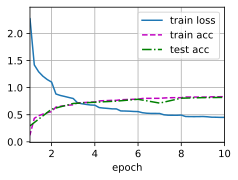

In [33]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)

### 6.6.3. Tóm tắt
* Mạng nơ-ron tích chập (gọi tắt là ConvNet) là một mạng sử dụng các tầng tích chập.
* Trong ConvNet, ta xen kẽ các phép tích chập, các hàm phi tuyến và các phép gộp.
* Độ phân giải được giảm xuống trước khi tạo một đầu ra thông qua một (hoặc nhiều) tầng kết nối dày đặc.
* LeNet là mạng ConvNet đầu tiên được triển khai thành công.

### 6.6.4. Bài tập
1. Điều gì sẽ xảy ra nếu ta thay thế phép gộp trung bình bằng phép gộp cực đại?
2. Thử cải thiện độ chính xác dự đoán dựa trên LeNet bằng cách:      
    * Điều chỉnh kích thước cửa sổ tích chập.      
    * Điều chỉnh số lượng kênh đầu ra.     
    * Điều chỉnh hàm kích hoạt (ReLU?).      
    * Điều chỉnh số lượng các tầng tích chập.      
    * Điều chỉnh số lượng các tầng kết nối đầy đủ.      
    * Điều chỉnh tốc độ học và các chi tiết huấn luyện khác (phương thức khởi tạo, số lượng epoch, v.v.)
3. Thử sử dụng mạng đã cải tiến ở phần 3 với tập dữ liệu MNIST ban đầu.
4. Hiển thị các giá trị kích hoạt của tầng thứ nhất và tầng thứ hai của LeNet với các đầu vào khác nhau (ví dụ: áo len, áo khoác).